<a href="https://colab.research.google.com/github/abhijadhav14/PythonPractice/blob/main/bda_teamd210_Sequential_ese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfl-punt-analytic-with-suggested-rule-change/__results__.html
/kaggle/input/nfl-punt-analytic-with-suggested-rule-change/__resultx__.html
/kaggle/input/nfl-punt-analytic-with-suggested-rule-change/__notebook__.ipynb
/kaggle/input/nfl-punt-analytic-with-suggested-rule-change/__output__.json
/kaggle/input/nfl-punt-analytic-with-suggested-rule-change/punt_play_data.csv
/kaggle/input/nfl-punt-analytic-with-suggested-rule-change/custom.css
/kaggle/input/nfl-punt-analytic-with-suggested-rule-change/__results___files/__results___20_1.png
/kaggle/input/nfl-punt-analytic-with-suggested-rule-change/__results___files/__results___18_1.png
/kaggle/input/nfl-punt-analytic-with-suggested-rule-change/__results___files/__results___27_2.png
/kaggle/input/nfl-punt-analytic-with-suggested-rule-change/__results___files/__results___19_1.png
/kaggle/input/nfl-punt-analytic-with-suggested-rule-change/__results___files/__results___95_0.png
/kaggle/input/nfl-punt-analytic-with-suggested-rule-chang

In [ ]:
def reorient(df, flip_left=False):


    df = df.drop_duplicates(subset=['GameKey',"PlayID",'GSISID'])

    return_team_role = ['PDL1','PDL2','PDL3','PDL4','PDL5','PDL6','PDM','PDR1','PDR2','PDR3','PDR4','PDR5', 'PDR6','PFB','PLL','PLL1','PLL2','PLL3','PLM','PLR','PLR1','PLR2','PLR3','VL','VLi','VLo','VR','VRi','VRo','PR']

    df['IsReturner'] = df.Role == 'PR'
    df['IsReturnTeam'] = df.Role.isin(return_team_role)

    punt_team_data = df[df.IsReturnTeam == False].groupby(['GameKey','PlayID'])['x'].mean().reset_index()
    punt_team_data.columns = ['GameKey','PlayID','punt_team_x']
    returner_team_data = df[df.Role == 'PR'].groupby(['GameKey','PlayID'])['x'].mean().reset_index()
    returner_team_data.columns = ['GameKey','PlayID','returner_x']
    play_data = pd.merge(punt_team_data,returner_team_data,how='inner')
    play_data['ToLeft'] = play_data.returner_x < play_data.punt_team_x
    df = pd.merge(df,play_data[['GameKey','PlayID','ToLeft']],on=['GameKey','PlayID'])

    df.loc[df.ToLeft, 'x'] = 120 - df.loc[df.ToLeft, 'x']
    df.loc[df.ToLeft, 'y'] = 160 / 3 - df.loc[df.ToLeft, 'y']
    df.loc[df.ToLeft, 'o'] = np.mod(180 + df.loc[df.ToLeft, 'o'], 360)
    df['dir'] = 90 - df.dir
    df.loc[df.ToLeft, 'dir'] = np.mod(180 + df.loc[df.ToLeft, 'dir'], 360)
    df.loc[df.IsReturnTeam, 'dir'] = df.loc[df.IsReturnTeam, 'dir'].fillna(0).values
    df.loc[~df.IsReturnTeam, 'dir'] = df.loc[~df.IsReturnTeam, 'dir'].fillna(180).values

    if flip_left:
        tmp = df[df['IsReturner']].copy()
        # df['left'] = df.Y < 160/6
        tmp['left'] = tmp.dir < 0
        df = df.merge(tmp[['GameKey','PlayID', 'left']], how='left', on=['GameKey','PlayID'])
        df['y'] = df.y
        df.loc[df["left"], 'y'] = 160 / 3 - df.loc[df["left"], 'y']
        df['dir'] = df.dir
        df.loc[df["left"], 'dir'] = np.mod(- df.loc[df["left"], 'dir'], 360)
        df.drop('left', axis=1, inplace=True)

    df["S"] = df["dis"] * 10
    df['x_dir'] = np.cos((np.pi / 180) * df.dir)
    df['y_dir'] = np.sin((np.pi / 180) * df.dir)
    df['x_S'] = df.x_dir * df.S
    df['y_S'] = df.y_dir * df.S

    return df


def merge_returnerfeats(df):
    returner_feats = df[df['Role'] == 'PR'].drop_duplicates()
    returner_feats = returner_feats[['GameKey',"PlayID", "x", "y", "x_S", "y_S"]]
    returner_feats = returner_feats.rename(
        columns={"x": "Returner_x", "y": "Returner_y", "x_S": "Returner_x_S", "y_S": "Returner_y_S"})
    df = df.merge(returner_feats, how="left", on=['GameKey',"PlayID"]).drop_duplicates(subset=['GameKey',"PlayID",'GSISID'])

    return df

def scaling(feats, sctype="standard"):
    v1 = []
    v2 = []
    for i in range(feats.shape[1]):
        feats_ = feats[:, i, :]
        if sctype == "standard":
            mean_ = np.mean(feats_)
            std_ = np.std(feats_)
            feats[:, i, :] -= mean_
            feats[:, i, :] /= std_
            v1.append(mean_)
            v2.append(std_)
        elif sctype == "minmax":
            max_ = np.max(feats_)
            min_ = np.min(feats_)
            feats[:, i, :] = (feats_ - min_) / (max_ - min_)
            v1.append(max_)
            v2.append(min_)

    return feats, v1, v2

In [ ]:
def create_features(df):
    xysdir_o = df[(df.IsReturnTeam == True) & (df.IsReturner == False)][['x','y','x_S','y_S']].values
    xysdir_rush = df[df.IsReturner == True][['x','y','x_S','y_S']].values
    xysdir_d = df[df.IsReturnTeam == False][['x','y','x_S','y_S']].values

    off_x = np.array(df[(df.IsReturnTeam == True) & (df.IsReturner == False)].groupby(['GameKey','PlayID'])['x'].apply(np.array))
    def_x = np.array(df[(df.IsReturnTeam == False) ].groupby(['GameKey','PlayID'])['x'].apply(np.array))
    off_y = np.array(df[(df.IsReturnTeam == True) & (df.IsReturner == False)].groupby(['GameKey','PlayID'])['y'].apply(np.array))
    def_y = np.array(df[(df.IsReturnTeam == False) ].groupby(['GameKey','PlayID'])['y'].apply(np.array))
    off_sx = np.array(df[(df.IsReturnTeam == True) & (df.IsReturner == False)].groupby(['GameKey','PlayID'])['x_S'].apply(np.array))
    def_sx = np.array(df[(df.IsReturnTeam == False) ].groupby(['GameKey','PlayID'])['x_S'].apply(np.array))
    off_sy = np.array(df[(df.IsReturnTeam == True) & (df.IsReturner == False)].groupby(['GameKey','PlayID'])['y_S'].apply(np.array))
    def_sy = np.array(df[(df.IsReturnTeam == False) ].groupby(['GameKey','PlayID'])['y_S'].apply(np.array))

    player_vector = []
    player_vector_aug = []
    for play in range(len(off_x)):
        player_feat, player_feat_aug = player_feature(off_x[play],def_x[play],off_y[play],def_y[play],off_sx[play],def_sx[play],
                                     off_sy[play],def_sy[play],xysdir_rush[play])
        player_vector.append(player_feat)
        player_vector_aug.append(player_feat_aug)

    return np.array(player_vector), np.array(player_vector_aug)


def player_feature(off_x,def_x,off_y,def_y,off_sx,def_sx,off_sy,def_sy,xysdir_rush):
    if(len(off_x)<10):
        off_x = np.pad(off_x,(10-len(off_x),0), 'mean' )
        off_y = np.pad(off_y,(10-len(off_y),0), 'mean' )
        off_sx = np.pad(off_sx,(10-len(off_sx),0), 'mean' )
        off_sy = np.pad(off_sy,(10-len(off_sy),0), 'mean' )
    if(len(def_x)<11):
        def_x = np.pad(def_x,(11-len(def_x),0), 'mean' )
        def_y = np.pad(def_y,(11-len(def_y),0), 'mean' )
        def_sx = np.pad(def_sx,(11-len(def_sx),0), 'mean' )
        def_sy = np.pad(def_sy,(11-len(def_sy),0), 'mean' )

    dist_def_off_x = def_x.reshape(-1,1)-off_x.reshape(1,-1)
    dist_def_off_sx = def_sx.reshape(-1,1)-off_sx.reshape(1,-1)
    dist_def_off_y = def_y.reshape(-1,1)-off_y.reshape(1,-1)
    dist_def_off_sy = def_sy.reshape(-1,1)-off_sy.reshape(1,-1)
    dist_def_rush_x = def_x.reshape(-1,1)-np.repeat(xysdir_rush[0],10).reshape(1,-1)
    dist_def_rush_y = def_y.reshape(-1,1)-np.repeat(xysdir_rush[1],10).reshape(1,-1)
    dist_def_rush_sx = def_sx.reshape(-1,1)-np.repeat(xysdir_rush[2],10).reshape(1,-1)
    dist_def_rush_sy = def_sy.reshape(-1,1)-np.repeat(xysdir_rush[3],10).reshape(1,-1)
    def_sx = np.repeat(def_sx,10).reshape(11,-1)
    def_sy = np.repeat(def_sy,10).reshape(11,-1)
    feats = [dist_def_off_x, dist_def_off_sx, dist_def_off_y, dist_def_off_sy, dist_def_rush_x, dist_def_rush_y,
            dist_def_rush_sx, dist_def_rush_sy, def_sx, def_sy]
    feats_aug = [dist_def_off_x, dist_def_off_sx, -1*dist_def_off_y, -1*dist_def_off_sy, dist_def_rush_x,
                 -1*dist_def_rush_y, dist_def_rush_sx, -1*dist_def_rush_sy, def_sx, -1*def_sy]

    return np.stack(feats), np.stack(feats_aug)

# def create_features_nearest(df):
#     xysdir_o = df[(df.IsReturnTeam == True) & (df.IsReturner == False)][['x','y','x_S','y_S']].values
#     xysdir_rush = df[df.IsReturner == True][['x','y','x_S','y_S']].values
#     xysdir_d = df[df.IsReturnTeam == False][['x','y','x_S','y_S']].values

#     off_x = np.array(df[(df.IsReturnTeam == True) & (df.IsReturner == False)].groupby(['GameKey','PlayID'])['x'].apply(np.array))
#     def_x = np.array(df[(df.IsReturnTeam == False) ].groupby(['GameKey','PlayID'])['x'].apply(np.array))
#     off_y = np.array(df[(df.IsReturnTeam == True) & (df.IsReturner == False)].groupby(['GameKey','PlayID'])['y'].apply(np.array))
#     def_y = np.array(df[(df.IsReturnTeam == False) ].groupby(['GameKey','PlayID'])['y'].apply(np.array))
#     off_sx = np.array(df[(df.IsReturnTeam == True) & (df.IsReturner == False)].groupby(['GameKey','PlayID'])['x_S'].apply(np.array))
#     def_sx = np.array(df[(df.IsReturnTeam == False) ].groupby(['GameKey','PlayID'])['x_S'].apply(np.array))
#     off_sy = np.array(df[(df.IsReturnTeam == True) & (df.IsReturner == False)].groupby(['GameKey','PlayID'])['y_S'].apply(np.array))
#     def_sy = np.array(df[(df.IsReturnTeam == False) ].groupby(['GameKey','PlayID'])['y_S'].apply(np.array))

#     player_vector = []
#     player_vector_aug = []
#     for play in range(len(off_x)):
#         player_feat, player_feat_aug = player_feature_nearest(off_x[play],def_x[play],off_y[play],def_y[play],off_sx[play],def_sx[play],
#                                      off_sy[play],def_sy[play],xysdir_rush[play])
#         player_vector.append(player_feat)
#         player_vector_aug.append(player_feat_aug)

#     return np.array(player_vector), np.array(player_vector_aug)


# def player_feature_nearest(off_x,def_x,off_y,def_y,off_sx,def_sx,off_sy,def_sy,xysdir_rush):
#     if(len(off_x)<10):
#         off_x = np.pad(off_x,(10-len(off_x),0), 'mean' )
#         off_y = np.pad(off_y,(10-len(off_y),0), 'mean' )
#         off_sx = np.pad(off_sx,(10-len(off_sx),0), 'mean' )
#         off_sy = np.pad(off_sy,(10-len(off_sy),0), 'mean' )
#     if(len(def_x)<11):
#         def_x = np.pad(def_x,(11-len(def_x),0), 'mean' )
#         def_y = np.pad(def_y,(11-len(def_y),0), 'mean' )
#         def_sx = np.pad(def_sx,(11-len(def_sx),0), 'mean' )
#         def_sy = np.pad(def_sy,(11-len(def_sy),0), 'mean' )

#     dist_def_rush_x = (def_x.reshape(-1,1)-xysdir_rush[0]).reshape(1,-1)
#     dist_def_rush_y = (def_y.reshape(-1,1)-xysdir_rush[1]).reshape(1,-1)
#     dist_def_rush_sx = (def_sx.reshape(-1,1)-xysdir_rush[2]).reshape(1,-1)
#     dist_def_rush_sy = (def_sy.reshape(-1,1)-xysdir_rush[3]).reshape(1,-1)

#     feats = [ dist_def_rush_x, dist_def_rush_y, dist_def_rush_sx, dist_def_rush_sy]
#     feats_aug = [ dist_def_rush_x, -1*dist_def_rush_y, dist_def_rush_sx, -1*dist_def_rush_sy]


#     return np.stack(feats), np.stack(feats_aug)


# def get_def_speed(df):
#     df_cp = df[~df.IsOnOffense].copy()
#     speed = 10*df_cp["dis"].T.values
#     speed = speed.reshape(-1, 1, 1, 11)
#     speed = np.repeat(speed, 10, axis=2)

#     return speed


# def get_dist(df, col1, col2, type="defence"):
#     if type == "defence":
#         df_cp = df[~df.IsOnOffense].copy()
#     elif type == "offence":
#         df_cp = df[df.IsOnOffense].copy()
#     dist = np.linalg.norm(df_cp[col1].values - df_cp[col2].values, axis=1)
#     dist = dist.T
#     dist = dist.reshape(-1, 1, 1, 11)
#     dist = np.repeat(dist, 10, axis=2)

#     return dist



# def dist_def_off(df, n_train, cols):
#     off_x = np.array(df[(df.IsOnOffense) & (~train.IsRusher)].groupby('PlayId')['x'].apply(np.array))
#     def_x = np.array(df[(~df.IsOnOffense) ].groupby('PlayId')['x'].apply(np.array))
#     off_y = np.array(df[(df.IsOnOffense) & (~train.IsRusher)].groupby('PlayId')['y'].apply(np.array))
#     def_y = np.array(df[(~df.IsOnOffense) ].groupby('PlayId')['y'].apply(np.array))
#     off_xs = np.array(df[(df.IsOnOffense) & (~train.IsRusher)].groupby('PlayId')['x_S'].apply(np.array))
#     def_xs = np.array(df[(~df.IsOnOffense) ].groupby('PlayId')['x_S'].apply(np.array))
#     off_ys = np.array(df[(df.IsOnOffense) & (~train.IsRusher)].groupby('PlayId')['y_S'].apply(np.array))
#     def_ys = np.array(df[(~df.IsOnOffense) ].groupby('PlayId')['y_S'].apply(np.array))
#     feats = []
#     for play in range(len(off_x)):
#         dist_x = off_x[play].reshape(-1, 1) - def_x[play].reshape(1, -1)
#         dist_y = off_y[play].reshape(-1, 1) - def_y[play].reshape(1, -1)
#         dist = np.concatenate([dist_x[:, :, np.newaxis], dist_y[:, :, np.newaxis]], axis=2)
#         dist_xy = np.linalg.norm(dist.astype(np.float64), axis=2)
#         dist_xs = off_xs[play].reshape(-1, 1) - def_xs[play].reshape(1, -1)
#         dist_ys = off_ys[play].reshape(-1, 1) - def_ys[play].reshape(1, -1)
#         dist = np.concatenate([dist_xs[:, :, np.newaxis], dist_ys[:, :, np.newaxis]], axis=2)
#         dist_xys = np.linalg.norm(dist.astype(np.float64), axis=2)
#         feats.append(np.concatenate([dist_xy[np.newaxis, :], dist_xys[np.newaxis, :]], axis=0))
#     return np.array(feats)

In [ ]:
import numpy as np


def crps(y_loss_val, y_pred):
    #y_true = np.clip(np.cumsum(y_loss_val, axis=1), 0, 1)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
    y_pred[:, :99-30] = 0.0
    y_pred[:, 50+99:] = 1.0
    val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * y_loss_val.shape[0])
    crps = np.round(val_s, 6)

    return crps


In [ ]:
import numpy as np


def crps(y_loss_val, y_pred):
    #y_true = np.clip(np.cumsum(y_loss_val, axis=1), 0, 1)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
    y_pred[:, :99-30] = 0.0
    y_pred[:, 50+99:] = 1.0
    val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * y_loss_val.shape[0])
    crps = np.round(val_s, 6)

    return crps

In [ ]:
from torch import nn


class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class CnnModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(10, 128, kernel_size=1, stride=1, bias=False),
            nn.CELU(inplace=True),
            nn.Conv2d(128, 160, kernel_size=1, stride=1, bias=False),
            nn.CELU(inplace=True),
            nn.Conv2d(160, 128, kernel_size=1, stride=1, bias=False),
            nn.CELU(inplace=True)
        )
        self.pool1 = nn.AdaptiveAvgPool2d((1, 11))

        self.conv2 = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 160, kernel_size=(1, 1), stride=1, bias=False),
            nn.CELU(inplace=True),
            nn.BatchNorm2d(160),
            nn.Conv2d(160, 96, kernel_size=(1, 1), stride=1, bias=False),
            nn.CELU(inplace=True),
            nn.BatchNorm2d(96),
            nn.Conv2d(96, 96, kernel_size=(1, 1), stride=1, bias=False),
            nn.CELU(inplace=True),
            nn.BatchNorm2d(96),
        )
        self.pool2 = nn.AdaptiveAvgPool2d((1, 1))

        self.last_linear = nn.Sequential(
            Flatten(),
            nn.Linear(96, 256),
            nn.LayerNorm(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.last_linear(x)

        return x

In [ ]:
import os
import random

import numpy as np
import torch


def seed_torch(seed=1029):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
import logging
import sys

LOGGER = logging.getLogger()
FORMATTER = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")


def setup_logger(out_file=None, stderr=True, stderr_level=logging.INFO, file_level=logging.DEBUG):
    LOGGER.handlers = []
    LOGGER.setLevel(min(stderr_level, file_level))

    if stderr:
        handler = logging.StreamHandler(sys.stderr)
        handler.setFormatter(FORMATTER)
        handler.setLevel(stderr_level)
        LOGGER.addHandler(handler)

    if out_file is not None:
        handler = logging.FileHandler(out_file)
        handler.setFormatter(FORMATTER)
        handler.setLevel(file_level)
        LOGGER.addHandler(handler)

    LOGGER.info("logger set up")
    return LOGGER

In [ ]:
import gc

import numpy as np
import torch


def train_one_epoch(model, train_loader, criterion, optimizer, device,
                    steps_upd_logging=500, accumulation_steps=1, scheduler=None):
    model.train()

    total_loss = 0.0
    for step, (x, targets) in enumerate(train_loader):
        #x= x.to(device)
        #targets = targets.to(device)
        optimizer.zero_grad()

        logits = model(x)
        #_, targets = targets.max(dim=1)
        loss = criterion(logits, targets)
        loss.backward()

        if (step + 1) % accumulation_steps == 0:  # Wait for several backward steps
            optimizer.step()  # Now we can do an optimizer step

        total_loss += loss.item()

        if scheduler is not None:
            scheduler.step()

        if (step + 1) % steps_upd_logging == 0:
            LOGGER.info('Train loss on step {} was {}'.format(step + 1, round(total_loss / (step + 1), 5)))


    return total_loss / (step + 1)

def validate(model, val_loader, criterion, device):
    model.eval()

    val_loss = 0.0
    true_ans_list = []
    preds_cat = []
    for step, (x, targets) in enumerate(val_loader):
        #x= x.to(device)
        #targets = targets.to(device)

        logits = model(x)
        #_, targets = targets.max(dim=1)
        loss = criterion(logits, targets)
        val_loss += loss.item()

        targets = targets.float().detach().numpy()
        logits = torch.softmax(logits, 1).float().detach().numpy()
        true_ans_list.append(targets)
        preds_cat.append(logits)

        del x, targets, logits
        gc.collect()

    all_true_ans = np.concatenate(true_ans_list, axis=0)
    all_preds = np.concatenate(preds_cat, axis=0)

    return all_preds, all_true_ans, val_loss / (step + 1)

In [ ]:
import torch
import torch.nn as nn


class CRPSLoss(nn.Module):
    def __init__(self, n_class=199):
        super().__init__()
        self.n_class = n_class
        self.mse = torch.nn.MSELoss()

    def forward(self, y_pred, y_true):
        y_pred = torch.softmax(y_pred, 1)
        y_pred = torch.clamp(torch.cumsum(y_pred, 1), 0, 1)
        #crps = torch.sum(torch.sum((y_true - y_pred) ** 2, 1), 0) / (self.n_class * y_true.shape[0])
        crps = self.mse(y_pred, y_true)
        return crps

In [ ]:
from torch.optim import Optimizer


class OneCycleLR:
    """ Sets the learing rate of each parameter group by the one cycle learning rate policy
    proposed in https://arxiv.org/pdf/1708.07120.pdf.
    It is recommended that you set the max_lr to be the learning rate that achieves
    the lowest loss in the learning rate range test, and set min_lr to be 1/10 th of max_lr.
    So, the learning rate changes like min_lr -> max_lr -> min_lr -> final_lr,
    where final_lr = min_lr * reduce_factor.
    Note: Currently only supports one parameter group.
    Args:
        optimizer:             (Optimizer) against which we apply this scheduler
        num_steps:             (int) of total number of steps/iterations
        lr_range:              (tuple) of min and max values of learning rate
        momentum_range:        (tuple) of min and max values of momentum
        annihilation_frac:     (float), fracion of steps to annihilate the learning rate
        reduce_factor:         (float), denotes the factor by which we annihilate the learning rate at the end
        last_step:             (int), denotes the last step. Set to -1 to start training from the beginning
    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> scheduler = OneCycleLR(optimizer, num_steps=num_steps, lr_range=(0.1, 1.))
        >>> for epoch in range(epochs):
        >>>     for step in train_dataloader:
        >>>         train(...)
        >>>         scheduler.step()
    Useful resources:
        https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6
        https://medium.com/vitalify-asia/whats-up-with-deep-learning-optimizers-since-adam-5c1d862b9db0
    """

    def __init__(self,
                 optimizer: Optimizer,
                 num_steps: int,
                 lr_range: tuple = (0.1, 1.),
                 momentum_range: tuple = (0.85, 0.95),
                 annihilation_frac: float = 0.1,
                 reduce_factor: float = 0.01,
                 last_step: int = -1):
        # Sanity check
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(type(optimizer).__name__))
        self.optimizer = optimizer

        self.num_steps = num_steps

        self.min_lr, self.max_lr = lr_range[0], lr_range[1]
        assert self.min_lr < self.max_lr, \
            "Argument lr_range must be (min_lr, max_lr), where min_lr < max_lr"

        self.min_momentum, self.max_momentum = momentum_range[0], momentum_range[1]
        assert self.min_momentum < self.max_momentum, \
            "Argument momentum_range must be (min_momentum, max_momentum), where min_momentum < max_momentum"

        self.num_cycle_steps = int(num_steps * (1. - annihilation_frac))  # Total number of steps in the cycle
        self.final_lr = self.min_lr * reduce_factor

        self.last_step = last_step

        if self.last_step == -1:
            self.step()

    def state_dict(self):
        """Returns the state of the scheduler as a :class:`dict`.
        It contains an entry for every variable in self.__dict__ which
        is not the optimizer. (Borrowed from _LRScheduler class in torch.optim.lr_scheduler.py)
        """
        return {key: value for key, value in self.__dict__.items() if key != 'optimizer'}

    def load_state_dict(self, state_dict):
        """Loads the schedulers state. (Borrowed from _LRScheduler class in torch.optim.lr_scheduler.py)
        Arguments:
            state_dict (dict): scheduler state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        self.__dict__.update(state_dict)

    def get_lr(self):
        return self.optimizer.param_groups[0]['lr']

    def get_momentum(self):
        return self.optimizer.param_groups[0]['momentum']

    def step(self):
        """Conducts one step of learning rate and momentum update
        """
        current_step = self.last_step + 1
        self.last_step = current_step

        if current_step <= self.num_cycle_steps // 2:
            # Scale up phase
            scale = current_step / (self.num_cycle_steps // 2)
            lr = self.min_lr + (self.max_lr - self.min_lr) * scale
            momentum = self.max_momentum - (self.max_momentum - self.min_momentum) * scale
        elif current_step <= self.num_cycle_steps:
            # Scale down phase
            scale = (current_step - self.num_cycle_steps // 2) / (self.num_cycle_steps - self.num_cycle_steps // 2)
            lr = self.max_lr - (self.max_lr - self.min_lr) * scale
            momentum = self.min_momentum + (self.max_momentum - self.min_momentum) * scale
        elif current_step <= self.num_steps:
            # Annihilation phase: only change lr
            scale = (current_step - self.num_cycle_steps) / (self.num_steps - self.num_cycle_steps)
            lr = self.min_lr - (self.min_lr - self.final_lr) * scale
            momentum = None
        else:
            # Exceeded given num_steps: do nothing
            return

        self.optimizer.param_groups[0]['lr'] = lr
        if momentum:
            self.optimizer.param_groups[0]['momentum'] = momentum

In [ ]:
import gc
import sys
import time

import json
import pandas as pd
import numpy as np
from contextlib import contextmanager
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from glob import glob

#from trainer import train_one_epoch, validate

# ===============
# Constants
# ===============
NGS_path = glob('/kaggle/input/NFL-Punt-Analytics-Competition/NGS/*')
DATA_DIR = "../input/nfl-big-data-bowl-2020"
TRAIN_PATH = os.path.join(DATA_DIR, "train.csv")
LOGGER_PATH = "log.txt"
TARGET_COLUMNS = 'return_yards'
N_CLASSES = 199

# ===============
# Settings
# ===============
SEED = np.random.randint(100000)
device = "cuda"
N_SPLITS = 5
BATCH_SIZE = 64
TTA = True
EXP_ID = "exp1"
epochs = 50
EXP_ID = "exp1_reproduce"

setup_logger(out_file=LOGGER_PATH)
seed_torch(SEED)
LOGGER.info("seed={}".format(SEED))


@contextmanager
def timer(name):
    t0 = time.time()
    yield
    LOGGER.info('[{}] done in {} s'.format(name, round(time.time() - t0, 2)))


with timer('load data'):
    play_information_data = pd.read_csv('/kaggle/input/nfl-punt-analytic-with-suggested-rule-change/punt_play_data.csv')
    player_role_data = pd.read_csv('/kaggle/input/NFL-Punt-Analytics-Competition/play_player_role_data.csv')
    train = pd.DataFrame({})
    for path in NGS_path:
        data = pd.read_csv(path)
        data = pd.merge(data[data.Event == 'punt_received'],play_information_data[['GameKey' ,'PlayID' ,'return_yards']])
        data = pd.merge(data,player_role_data)
        train = pd.concat([train,data[data.Event == 'punt_received']])
        del data
    train = train.dropna(subset=['return_yards'])



    #season = train["Season_Year"][::22].values


with timer('create features'):
    train = reorient(train, flip_left=True)
    train = merge_returnerfeats(train).sort_values('x')

    game_id = train.groupby(['GameKey' ,'PlayID'])['x'].first().reset_index()['GameKey'].values
    y_mae = train.groupby(['GameKey','PlayID'])[TARGET_COLUMNS].first().reset_index()[TARGET_COLUMNS].values
    y_mae = np.where(y_mae < -30, -30, y_mae)
    y_mae = np.where(y_mae > 50, 50, y_mae)
    y_crps = np.zeros((y_mae.shape[0], 199))
    for idx, target in enumerate(list(y_mae)):
        y_crps[idx][99 + int(target):] = 1

    n_train = len(train.groupby(['GameKey','PlayID']))

    n_df = len(train)
    x, x_aug = create_features(train)
    x = np.concatenate([x, x_aug], axis=0)

    x, sc_mean, sc_std = scaling(x)
    x_aug = x[n_train:]
    x = x[:n_train]
    #LOGGER.info(len(x), len(x_aug))

with timer('split data'):
#     x_2017, y_crps_2017, y_mae_2017 = x[season==2017], y_crps[season==2017], y_mae[season==2017]
    x_usage, y_crps_usage, y_mae_usage = x, y_crps, y_mae
#     x_aug_2017 = x_aug[season==2017]
    x_aug_usage = x_aug
    folds = GroupKFold(n_splits=N_SPLITS).split(y_mae_usage, y_mae_usage, groups=game_id)

with timer('train'):
    scores = []
    for n_fold, (train_idx, val_idx) in enumerate(folds):
        with timer('create model'):
            x_train, y_train, y_train_mae = x_usage[train_idx], y_crps_usage[train_idx], y_mae_usage[train_idx]
            x_val, y_val, y_val_mae = x_usage[val_idx], y_crps_usage[val_idx], y_mae_usage[val_idx]
            x_aug_train, x_aug_val = x_aug_usage[train_idx], x_aug_usage[val_idx]

            # add 2017 data
#             x_train = np.concatenate([x_train, x_2017, x_aug_2017, x_aug_train], axis=0)
#             y_train = np.concatenate([y_train, y_crps_2017, y_crps_2017, y_train], axis=0)

            train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
            train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
            val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
            val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
            val_dataset_aug = TensorDataset(torch.tensor(x_aug_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
            val_loader_aug = DataLoader(val_dataset_aug, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
            del train_dataset, val_dataset
            gc.collect()

            model = CnnModel(num_classes=N_CLASSES)
            #model.to(device)

            num_steps = len(x_train) // BATCH_SIZE
            #criterion = torch.nn.CrossEntropyLoss()
            criterion = CRPSLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
            #scheduler = OneCycleLR(optimizer, num_steps=num_steps, lr_range=(0.0005, 0.001))
            scheduler = None

        with timer('train fold{}'.format(n_fold)):
            best_score = 999
            best_epoch = 0
            y_pred = np.zeros_like(y_crps)
            for epoch in range(1, epochs + 1):
                seed_torch(SEED + epoch)

                LOGGER.info("Starting {} epoch...".format(epoch))
                tr_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, scheduler=scheduler)
                LOGGER.info('Mean train loss: {}'.format(round(tr_loss, 5)))

                val_pred, y_true, val_loss = validate(model, val_loader, criterion, device)
                if TTA:
                    val_pred_aug, _, val_loss_aug = validate(model, val_loader_aug, criterion, device)
                    LOGGER.info('valid loss: {} valid loss aug: {}'.format(round(val_loss, 5), round(val_loss_aug, 5)))
                    val_loss = (val_loss + val_loss_aug) / 2
                    val_pred = (val_pred + val_pred_aug) / 2
                score = crps(y_val, val_pred)
                LOGGER.info('Mean valid loss: {} score: {}'.format(round(val_loss, 5), round(score, 5)))
                if score < best_score:
                    best_score = score
                    best_epoch = epoch
                    torch.save(model.state_dict(), '{}_fold{}.pth'.format(EXP_ID, n_fold))
                    y_pred[val_idx] = val_pred

            scores.append(best_score)
            LOGGER.info("best score={} on epoch={} fold={}".format(best_score, best_epoch, n_fold))
    LOGGER.info("score avg={}, score fold0={}, score fold1={}, score fold2={}, score fold3={}, score fold4={}".format(
        np.mean(scores), scores[0], scores[1], scores[2], scores[3], scores[4]))

2022-10-04 12:29:09,113 - INFO - logger set up
2022-10-04 12:29:09,118 - INFO - seed=46230
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
2022-10-04 12:32:10,249 - INFO - [load data] done in 181.13 s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [ ]:
print(model(torch.tensor(x_val, dtype=torch.float32)))

tensor([[-2.9345, -3.5135, -3.0092,  ..., -3.1132, -3.0310, -3.3582],
        [-3.0662, -3.2412, -3.3177,  ..., -2.5900, -3.4198, -3.3080],
        [-2.8059, -3.4830, -3.1034,  ..., -3.2263, -3.5511, -3.0009],
        ...,
        [-3.1106, -3.1485, -3.1191,  ..., -2.5150, -1.9142, -2.5577],
        [-3.1417, -3.2420, -3.2113,  ..., -2.4473, -2.8685, -2.6741],
        [-3.1915, -3.3236, -3.5163,  ..., -2.2839, -2.6101, -2.6754]],
       grad_fn=<AddmmBackward0>)


In [ ]:
y_preds = [torch.softmax(model(torch.tensor(x_val, dtype=torch.float32)), dim=1).float().detach().numpy() ]

In [ ]:
predict_yards = []
for i in range(len(y_preds[0])):
    predict_yards.append(np.sum(y_preds[0][i]*np.arange(-99,100)))

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Real Return Yards')

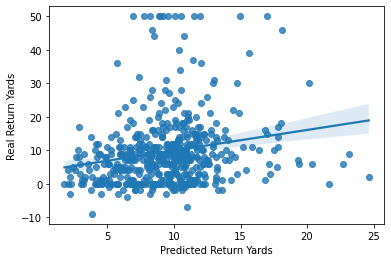

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.regplot(predict_yards,y_val_mae)
plt.xlabel('Predicted Return Yards')
plt.ylabel('Real Return Yards')

In [ ]:
test_x_punt = train[(train.PlayID == 1335) & (train.IsReturnTeam == True)]['x']
test_x_return = train[(train.PlayID == 1335) & (train.IsReturnTeam == False)]['x']
test_y_punt = train[(train.PlayID == 1335) & (train.IsReturnTeam == True)]['y']
test_y_return = train[(train.PlayID == 1335) & (train.IsReturnTeam == False)]['y']

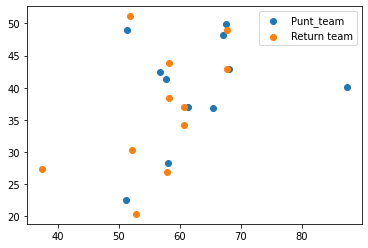

In [ ]:
plt.scatter(test_x_punt,test_y_punt)
plt.scatter(test_x_return,test_y_return)
plt.legend(('Punt_team','Return team'))

In [ ]:
train.to_csv('train.csv')

In [ ]:
print("best score: {:.2f}%".format(best_score * 3500))

best score: 88.13%
